In [1]:
# --- 1) Import libraries ------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score
)

import joblib

In [2]:
# --- 2) Load data -------------------------------------------------------------
FILE_PATH = r"C:\\Users\\chloe\\Downloads\\bank+marketing\\bank\\bank-full.csv"
df = pd.read_csv(FILE_PATH, sep=";")  # IMPORTANT: bank-full uses ';'

Shape: (45211, 17)
y
no     39922
yes     5289
Name: count, dtype: int64


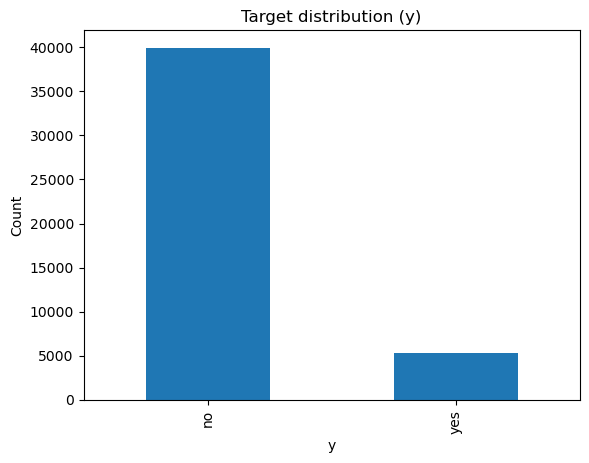

In [3]:
# --- 3) Quick checks / EDA (optional but good for notebook evidence) ----------
print("Shape:", df.shape)
print(df["y"].value_counts())
df["y"].value_counts().plot(kind="bar")
plt.title("Target distribution (y)")
plt.xlabel("y")
plt.ylabel("Count")
plt.show()

In [4]:
# --- 4) Feature Engineering 
# 4A) Create a more meaningful feature from pdays:

df_fe = df.copy()
df_fe["previously_contacted"] = (df_fe["pdays"] != 999).astype(int)

In [5]:
# 4B) Safe log transforms
# duration & campaign are non-negative → log1p is safe
df_fe["log_duration"] = np.log1p(df_fe["duration"])
df_fe["log_campaign"] = np.log1p(df_fe["campaign"])

# balance can be negative → use signed log transform
df_fe["log_balance"] = np.sign(df_fe["balance"]) * np.log1p(np.abs(df_fe["balance"]))


In [6]:
# 4C) Drop pdays 
if "pdays" in df_fe.columns:
    df_fe = df_fe.drop(columns=["pdays"])

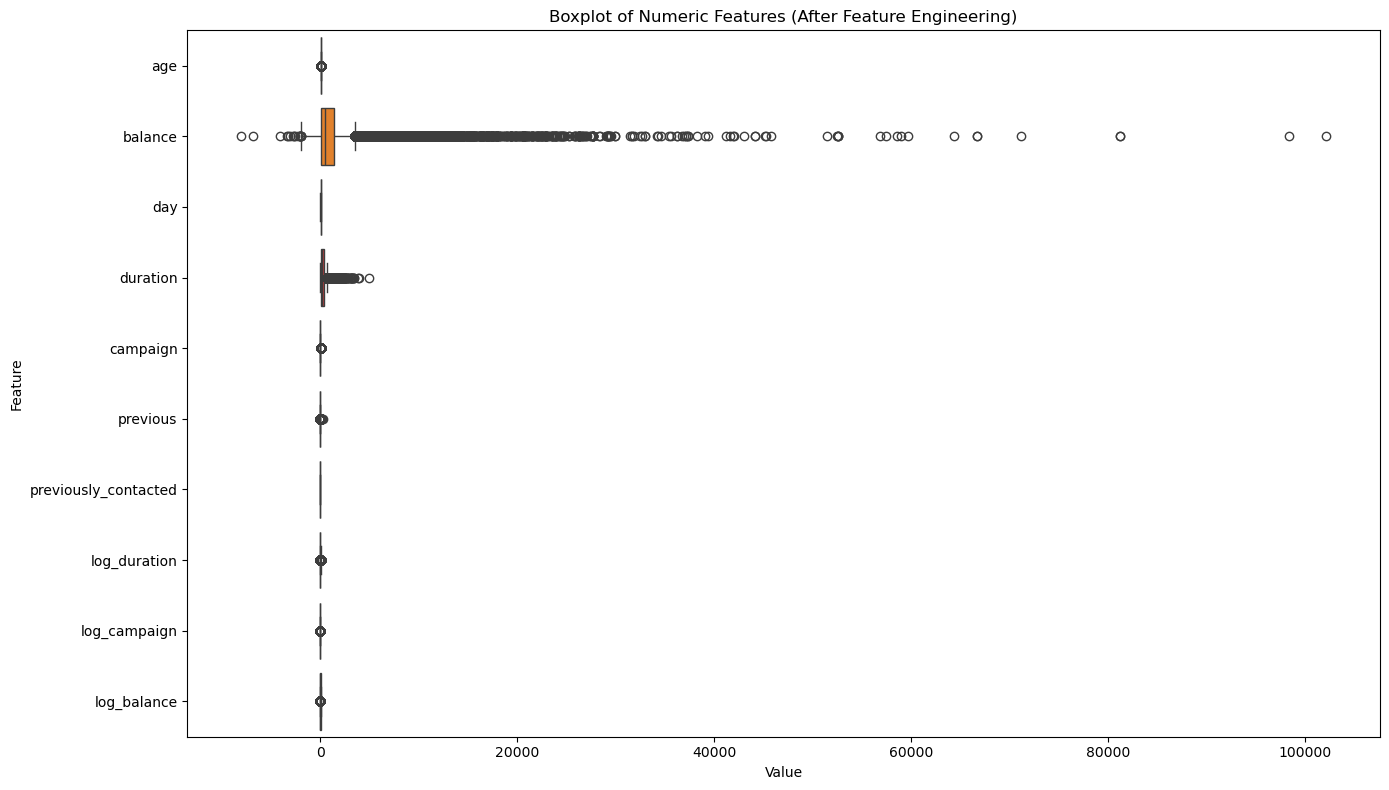

In [7]:
# --- 4D) Outlier detection using boxplots (after feature engineering) ---------
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns AFTER feature engineering
numeric_cols = df_fe.select_dtypes(include=["int64", "float64"]).columns

# Exclude target variable if still numeric (safety)
numeric_cols = numeric_cols.drop("y", errors="ignore")

plt.figure(figsize=(14, 8))
sns.boxplot(data=df_fe[numeric_cols], orient="h")
plt.title("Boxplot of Numeric Features (After Feature Engineering)")
plt.xlabel("Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [8]:
# --- 5) Split into X (features) and y (target) --------------------------------
col_y = "y"
y = df_fe[col_y]  # 'yes' / 'no'
X_raw = df_fe.drop(columns=[col_y])

# One-Hot Encode categorical columns
X = pd.get_dummies(X_raw, drop_first=True)

# --- Sanity check: remove inf and handle NaN (prevents training errors) -------
X = X.replace([np.inf, -np.inf], np.nan)

print("Total NaN in X:", X.isna().sum().sum())

# Fill numeric NaN with median (simple + school-appropriate)
X = X.fillna(X.median(numeric_only=True))


print("X shape after get_dummies:", X.shape)

Total NaN in X: 0
X shape after get_dummies: (45211, 45)


In [9]:
# --- 6) Train-test split ------------------------------------------------------
test_size = 0.3
random_state = 2025

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=test_size,
    random_state=random_state,
    stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (31647, 45) Test shape: (13564, 45)


In [10]:
# --- 7) Model 2A: Random Forest baseline -------------------------------------
rf_base = RandomForestClassifier(
    n_estimators=200,
    random_state=random_state,
    class_weight="balanced",   # helps minority 'yes'
    n_jobs=-1
)

rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

print("\n=== Random Forest (Baseline) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_base))
print("F1 (yes):", f1_score(y_test, y_pred_base, pos_label="yes"))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_base))
print("\nClassification Report:\n", classification_report(y_test, y_pred_base))


=== Random Forest (Baseline) ===
Accuracy: 0.9037894426422884
F1 (yes): 0.4560233430596082
Confusion Matrix:
 [[11712   265]
 [ 1040   547]]

Classification Report:
               precision    recall  f1-score   support

          no       0.92      0.98      0.95     11977
         yes       0.67      0.34      0.46      1587

    accuracy                           0.90     13564
   macro avg       0.80      0.66      0.70     13564
weighted avg       0.89      0.90      0.89     13564



In [11]:
# --- 8A) Define hyperparameter grid ------------------------------------------
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}


In [12]:
# --- 8B) Define base Random Forest model -------------------------------------
rf = RandomForestClassifier(
    random_state=random_state,
    class_weight="balanced",
    n_jobs=-1
)


In [13]:
# --- 8C) Set up RandomizedSearchCV -------------------------------------------
rf_rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=10,
    scoring="f1_macro",
    cv=3,
    random_state=random_state,
    n_jobs=-1,
    verbose=1
)


In [14]:
# --- 8D) Fit RandomizedSearchCV ----------------------------------------------
rf_rs.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,RandomForestC...om_state=2025)
,param_distributions,"{'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,'f1_macro'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,2025
,error_score,nan


In [15]:
# --- 8E) View best results ---------------------------------------------------
print("\n=== RandomizedSearchCV Results ===")
print("Best Params:", rf_rs.best_params_)
print("Best CV Score (f1_macro):", rf_rs.best_score_)

best_rf = rf_rs.best_estimator_



=== RandomizedSearchCV Results ===
Best Params: {'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': None}
Best CV Score (f1_macro): 0.7693883809444118


In [16]:
# --- 9) Evaluate tuned best model --------------------------------------------
y_pred_best = best_rf.predict(X_test)

print("\n=== Random Forest (Tuned / Best) ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("F1 (yes):", f1_score(y_test, y_pred_best, pos_label="yes"))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))


=== Random Forest (Tuned / Best) ===
Accuracy: 0.8959009141846063
F1 (yes): 0.6135741652983032
Confusion Matrix:
 [[11031   946]
 [  466  1121]]

Classification Report:
               precision    recall  f1-score   support

          no       0.96      0.92      0.94     11977
         yes       0.54      0.71      0.61      1587

    accuracy                           0.90     13564
   macro avg       0.75      0.81      0.78     13564
weighted avg       0.91      0.90      0.90     13564



In [17]:
# --- 10) Quick comparison summary --------------------------------------------
summary = pd.DataFrame({
    "Model": ["RF Baseline", "RF Tuned (Best)"],
    "Accuracy": [
        accuracy_score(y_test, y_pred_base),
        accuracy_score(y_test, y_pred_best)
    ],
    "F1_yes": [
        f1_score(y_test, y_pred_base, pos_label="yes"),
        f1_score(y_test, y_pred_best, pos_label="yes")
    ],
    "F1_macro": [
        f1_score(y_test, y_pred_base, average="macro"),
        f1_score(y_test, y_pred_best, average="macro")
    ]
})
print("\n=== Model Comparison ===")
print(summary)


=== Model Comparison ===
             Model  Accuracy    F1_yes  F1_macro
0      RF Baseline  0.903789  0.456023  0.701626
1  RF Tuned (Best)  0.895901  0.613574  0.776711


In [18]:
# --- 11) Save best model + feature columns -----------------------------------
joblib.dump(best_rf, "bank_model_v2_rf_best.pkl")
joblib.dump(X.columns.tolist(), "bank_feature_cols_v2.pkl")

print("\nSaved: bank_model_v2_rf_best.pkl")
print("Saved: bank_feature_cols_v2.pkl")


Saved: bank_model_v2_rf_best.pkl
Saved: bank_feature_cols_v2.pkl
